Assignment 4 (Due: Sunday, May 26, 2024)

The devised program estimates robustly, given very noisy and very sparse data of infected and recovered of a past epidemic, the basic reproduction number of the SIR model. To keep computation in limit, we assume gamma=1. The SIR model is implemented in a minimal and optimal way, using scaled variables and a scaled time. Only the ODE part is numerically integrated that needs to be integrated. The noisy number of infected and the number of recovered are highly correlated. This relationship helps MCMC infer the parameters. 

Get familiar with the commented MCMC code below.

Task:
Change the program to the SIRD model, by including (D)eaths, with rate $\mu$. Fix not only $\gamma=1$ but also $\beta=2.5$ (or to a higher value of your choice). 
Infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.
If you want, you can try to optimze the code (optional, very very hard). 
Also optional is: Does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given ?
You may use these (initial) conditions/parameters: $$i0 = 0.01, s0 = 0.99, r0 = 0, d0 = 0, f = 3.0, timestep = 0.5.$$
You may assume values for the respective $\sigma$'s (log-normal noises) in the range of $0.2-0.4$, but not lower than $0.1$. For assessment use HPD plots, or similar. Good luck and have fun.

In [55]:
# Assignment 4: SIR model, MCMC for R0
# Jan Nagler
# based on https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_API_introduction.htm
import numpy as np
import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline
import pymc as pm #install if necessary
from pymc.ode import DifferentialEquation
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore")  
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

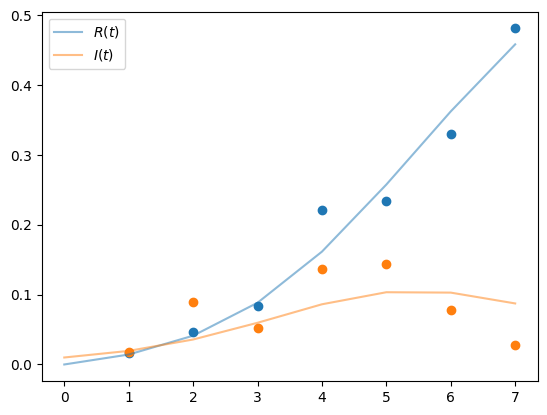

In [2]:
# Define initial conditions of SIR model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
f = 1.5 #3.0 # time factor, defines total time window range

timestep_data = 1 # dt for data (e.g., weekly)

# ODE SIR system, only parameter p[0]=R0, for scaled time t/gamma (optimized, and 1=gamma)
def SIR(y, t, p):
    #ds = -p[0]*y[0]*y[1] # we do not need susceptibles as S=1-I-R is determ dependent on i and r
    #dr = y[1] #component 0 = recovered, gamma=1 (will be returned directly)
    di = p[0]*(1-y[0]-y[1])*y[1] - y[1] #component 1 = infected, gamma=1 (SIR in one line)
    return [y[1], di] # return r(ecov) and i(nfect)
times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 1.7
gamma = 1

#N=S+R+I
#S(t)=N-R(t)-I(t)

#R0=beta/(mu+gamma)
R0=beta/(gamma)
#beta=2.5

#R0=2.5/(mu+1)

# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0], args=([beta],), rtol=1e-8) # r0 recovered, i0 infected  at t0

# Observational model for muliplicative noise
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.60]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [3]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data,5*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 2, #r(ecovered) and i(nfected) are states
    n_theta = 1, # beta=R0 only parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( "sigma", 1, shape=2 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0= pm.TruncatedNormal("R0", 2, 3, lower=1) # guess of how R0 distribution looks like = Gaussian, mean, lower bound=1: R0>=1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0], theta=[R0] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal("Y", mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS() # pm.Metropolis_Hastings()
    
    trace = pm.sample(400, step=step, cores=8, random_seed=44) #set here number of cores, to adapt for hardware


Output()

Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, R0]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 8 chains for 1_000 tune and 400 draw iterations (8_000 + 3_200 draws total) took 486 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R0,1.74,0.05,1.64,1.83,0.0,0.0,1661.0,1307.0,1.00
sigma[0],0.20,0.08,0.09,0.33,0.0,0.0,1518.0,1721.0,1.01
sigma[1],0.68,0.21,0.34,1.05,0.0,0.0,1982.0,1759.0,1.00


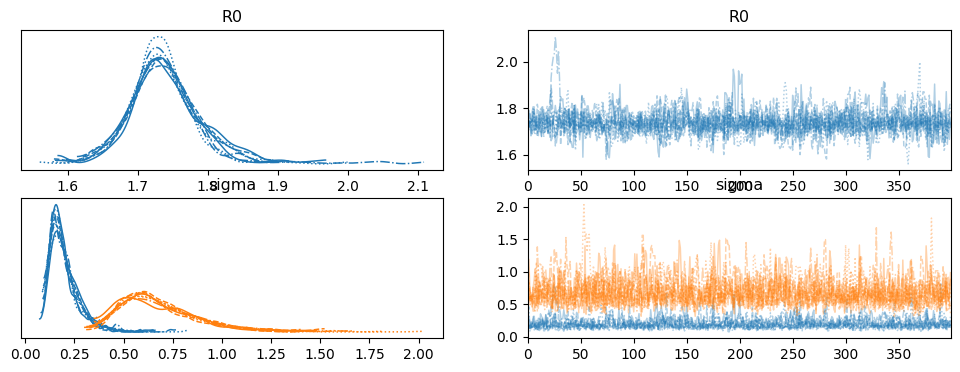

In [4]:
# Plot results (takes a while, be patient)
import arviz as az
az.plot_trace(trace)
pm.summary(trace).round(2)

array([[<Axes: ylabel='sigma\n0'>, <Axes: >],
       [<Axes: xlabel='R0', ylabel='sigma\n1'>,
        <Axes: xlabel='sigma\n0'>]], dtype=object)

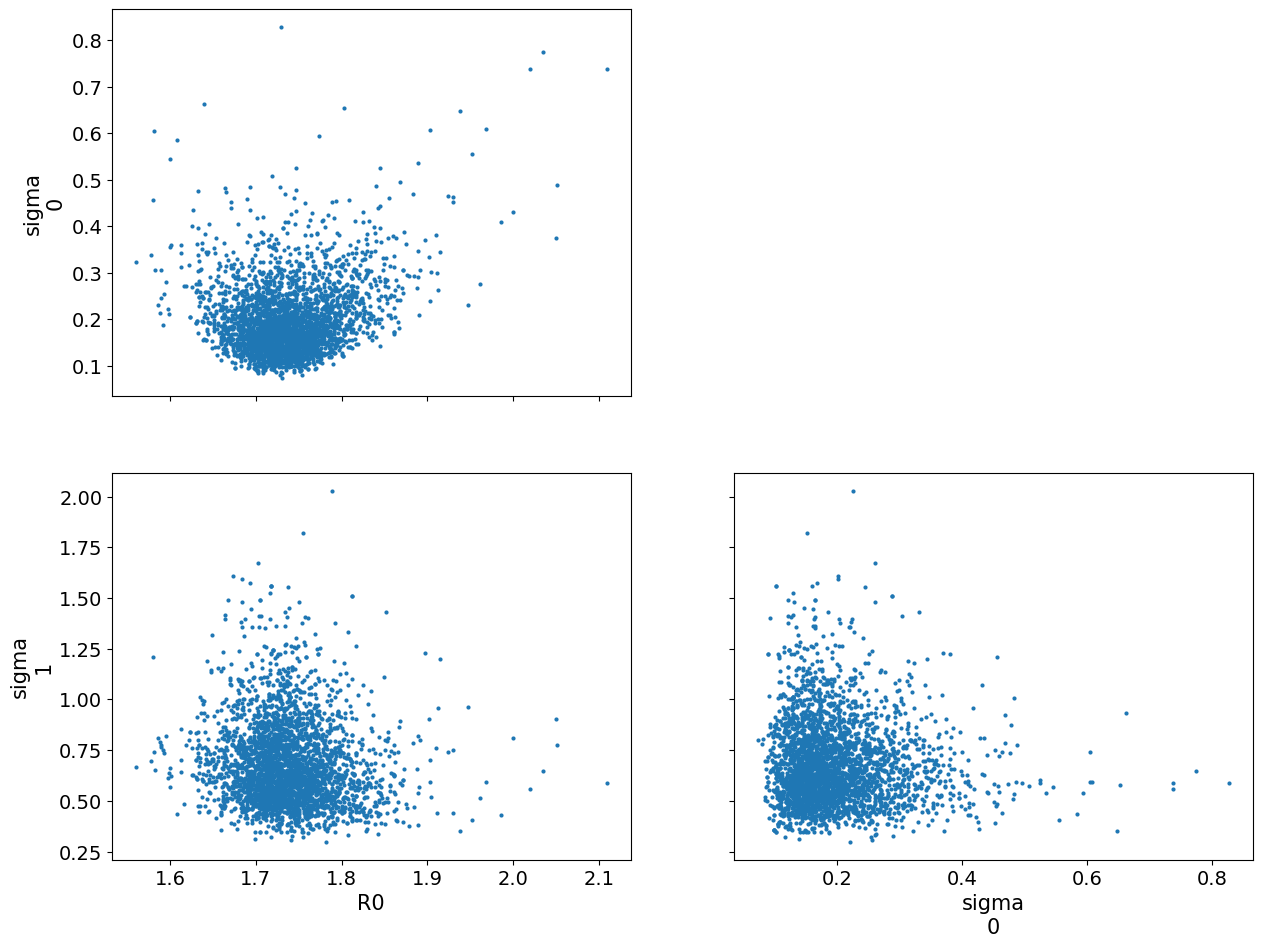

In [5]:
az.plot_pair(trace)

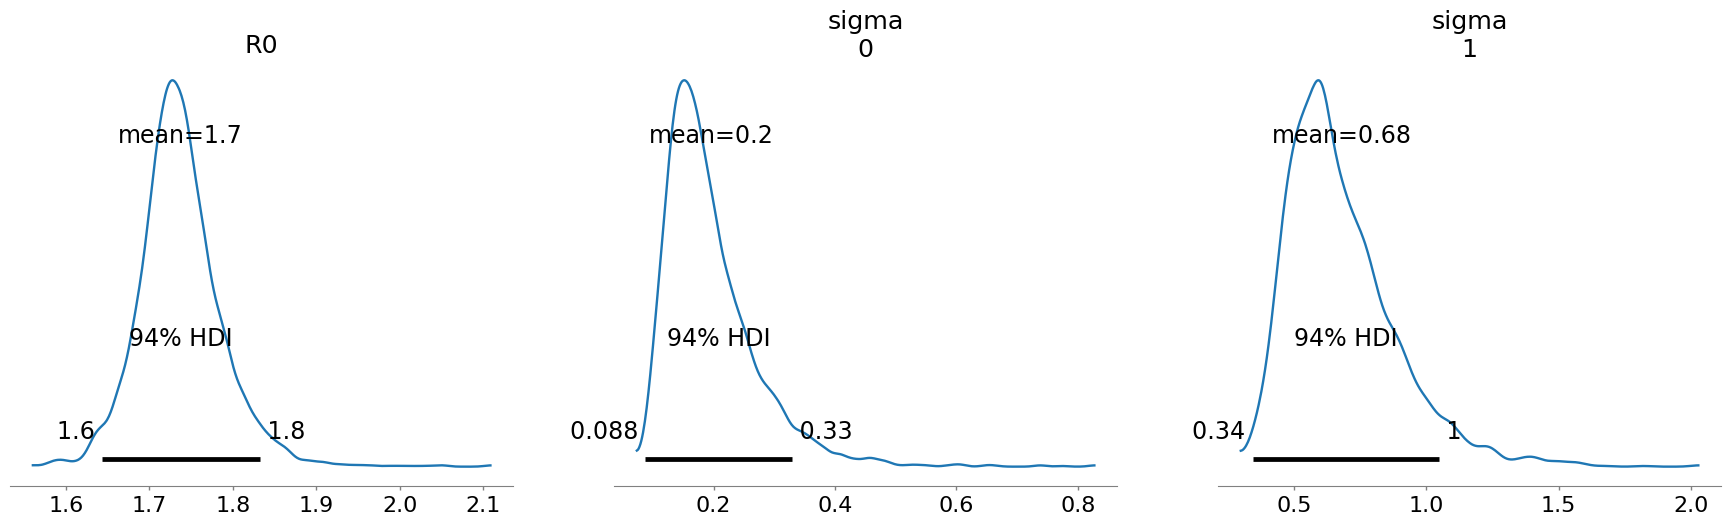

In [6]:
az.plot_posterior(
    trace,
textsize = 16)
#hdi_prob = 0.96)
plt.show()

In [7]:
print(beta) # ground truth 

1.7


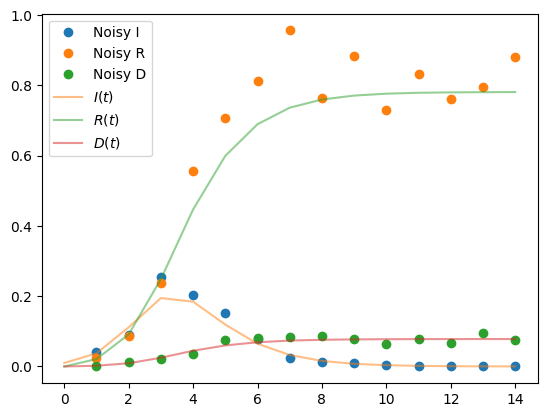

In [65]:
# Initial conditions and parameters
i0 = 0.01  # fraction infected at time t0=0 (1%)
r0 = 0.00  # fraction recovered at time t0=0
d0 = 0.00  # fraction dead at time t0=0
s0 = 0.99  # fraction susceptible at time t0=0
f = 3.0    # time factor, defines total time window range
timestep_data = 1  # dt for data (e.g., weekly)


def SIRD(y, t, p):
    beta, mu = p  # Unpack parameters beta (transmission rate) and mu (death rate)
    S, I, R, D = y  # Unpack current values of the compartments

    # Define the differential equations
    dSdt = -beta * S * I  # Susceptible individuals become infected
    dIdt = beta * S * I - I - mu * I  # Infected individuals can either recover, die, or remain infected
    dRdt = I  # Infected individuals recover (gamma=1 is assumed, so recovery rate is equal to the number of infected)
    dDdt = mu * I  # Infected individuals die at rate mu

    return [dSdt, dIdt, dRdt, dDdt] 

times = np.arange(0, 5 * f, timestep_data)

# Ground truth parameters
beta = 2.5
gamma = 1
mu = 0.1  # death rate

# Initial conditions vector
y0 = [s0, i0, r0, d0]

# Solve the ODE
y = odeint(SIRD, y0, times, args=([beta, mu],), rtol=1e-8)

# Observational model for multiplicative noise
sigma_I = 0.3
sigma_R = 0.2
sigma_D = 0.2

# Apply noise only to the infected, recovered, and deceased compartments
yobs_I = np.random.lognormal(mean=np.log(y[1:, 1]), sigma=sigma_I)
yobs_R = np.random.lognormal(mean=np.log(y[1:, 2]), sigma=sigma_R)
yobs_D = np.random.lognormal(mean=np.log(y[1:, 3]), sigma=sigma_D)

# Stack the noisy observations into a single array
yobs = np.vstack((yobs_I, yobs_R, yobs_D)).T

# Plot the deterministic curves and those with multiplicative noise
plt.plot(times[1:], yobs[:, 0], marker='o', linestyle='none', label='Noisy I')
plt.plot(times[1:], yobs[:, 1], marker='o', linestyle='none', label='Noisy R')
plt.plot(times[1:], yobs[:, 2], marker='o', linestyle='none', label='Noisy D')
plt.plot(times, y[:, 1], color='C1', alpha=0.5, label='$I(t)$')
plt.plot(times, y[:, 2], color='C2', alpha=0.5, label='$R(t)$')
plt.plot(times, y[:, 3], color='C3', alpha=0.5, label='$D(t)$')
plt.legend()
plt.show()

In [69]:
# ODE system container for the SIRD model
sird_model = DifferentialEquation(
    func=SIRD,
    times=times,
    n_states=4,  # S, I, R, D are states
    n_theta=2,  # beta and mu are parameters
    t0=0  # start from zero
)

In [70]:
# Define and perform MCMC
with pm.Model() as model:

    # Distribution of variances for log-normal noise
    sigma = pm.HalfCauchy("sigma", 1, shape=3)

    # Priors for beta and mu
    beta = pm.Normal("beta", 2.5, 0.5)  # Assume beta around 2.5
    mu = pm.Normal("mu", 0.1, 0.05)     # Assume mu around 0.1

    # Our deterministic SIRD curves
    sird_curves = sird_model(y0=[s0, i0, r0, d0], theta=[beta, mu])

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I, R, and D curves
    Y = pm.Lognormal("Y", mu=pm.math.log(sird_curves[:, 1:]), sigma=sigma, observed=yobs)

    start = pm.find_MAP()

    step = pm.NUTS()

    trace = pm.sample(400, step=step, tune=1000, cores=8, random_seed=44)

# Plot results (takes a while, be patient)
az.plot_trace(trace)
pm.summary(trace).round(2)
plt.show()

RuntimeError: The size of the array returned by func (21) does not match the size of y0 (28).
Apply node that caused the error: DifferentialEquation{func=<function SIRD at 0x1425220e0>, times=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5), n_states=4, n_theta=2, t0=0}([0.99 0.01 ... 0.   0.  ], MakeVector{dtype='float64'}.0)
Toposort index: 7
Inputs types: [TensorType(float64, shape=(4,)), TensorType(float64, shape=(2,))]
Inputs shapes: [(4,), (2,)]
Inputs strides: [(8,), (8,)]
Inputs values: [array([0.99, 0.01, 0.  , 0.  ]), array([2.5, 0.1])]
Outputs clients: [[Subtensor{:, start:}(DifferentialEquation{func=<function SIRD at 0x1425220e0>, times=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5), n_states=4, n_theta=2, t0=0}.0, 1)], []]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q6/rg_7lxjs1wx6080czdx8tpjm0000gn/T/ipykernel_9662/4260653034.py", line 12, in <module>
    sird_curves = sird_model(y0=[s0, i0, r0, d0], theta=[beta, mu])
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/pymc/ode/ode.py", line 170, in __call__
    states, sens = super().__call__(y0, theta, **kwargs)
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/pytensor/graph/op.py", line 292, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/pymc/ode/ode.py", line 144, in make_node
    states = self._otypes[0]()

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [71]:
# Define the DifferentialEquation object for the SIRD model
sird_model = DifferentialEquation(
    func=SIRD,
    times=np.arange(timestep_data, 5 * f, timestep_data),
    n_states=4,  # S, I, R, D are states
    n_theta=2,  # beta and mu are parameters
    t0=0  # start from zero
)

# Define and perform MCMC
with pm.Model() as model:

    # Priors for beta and mu
    beta = pm.Normal("beta", mu=2.5, sigma=0.5)  # Assume beta around 2.5
    mu = pm.Normal("mu", mu=0.1, sigma=0.05)     # Assume mu around 0.1

    # Our deterministic SIRD curves
    sird_curves = sird_model(y0=[s0, i0, r0, d0], theta=[beta, mu])

    # Distribution of variances for log-normal noise
    sigma = pm.HalfCauchy("sigma", beta=1, shape=3)

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I, R, and D curves
    Y = pm.Lognormal("Y", mu=pm.math.log(sird_curves[:, 1:]), sigma=sigma, observed=yobs)

    step = pm.NUTS()

    trace = pm.sample(400, step=step, tune=1000, cores=4, random_seed=44)

# Plot results (takes a while, be patient)
az.plot_trace(trace)
az.summary(trace).round(2)
plt.show()

RuntimeError: The size of the array returned by func (21) does not match the size of y0 (28).
Apply node that caused the error: DifferentialEquation{func=<function SIRD at 0x1425220e0>, times=(0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5), n_states=4, n_theta=2, t0=0}([0.99 0.01 ... 0.   0.  ], MakeVector{dtype='float64'}.0)
Toposort index: 7
Inputs types: [TensorType(float64, shape=(4,)), TensorType(float64, shape=(2,))]
Inputs shapes: [(4,), (2,)]
Inputs strides: [(8,), (8,)]
Inputs values: [array([0.99, 0.01, 0.  , 0.  ]), array([2.5, 0.1])]
Outputs clients: [[Subtensor{:, start:}(DifferentialEquation{func=<function SIRD at 0x1425220e0>, times=(0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5), n_states=4, n_theta=2, t0=0}.0, 1)], []]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/q6/rg_7lxjs1wx6080czdx8tpjm0000gn/T/ipykernel_9662/3383327742.py", line 18, in <module>
    sird_curves = sird_model(y0=[s0, i0, r0, d0], theta=[beta, mu])
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/pymc/ode/ode.py", line 170, in __call__
    states, sens = super().__call__(y0, theta, **kwargs)
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/pytensor/graph/op.py", line 292, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/Users/alexander/Library/Caches/pypoetry/virtualenvs/guided-studies-in-fin-management-9_NrfNku-py3.10/lib/python3.10/site-packages/pymc/ode/ode.py", line 144, in make_node
    states = self._otypes[0]()

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

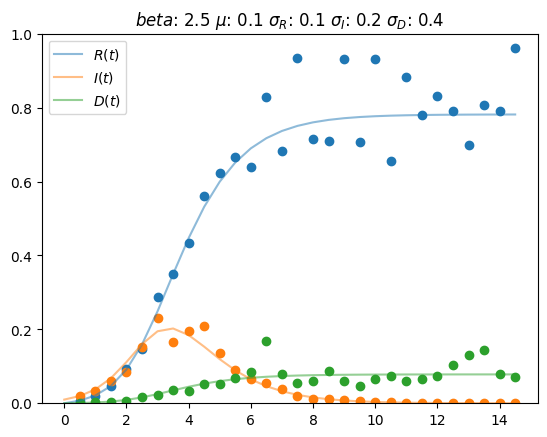

In [66]:
# Define initial conditions of SIR model
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
d0 = 0.00 # fraction of dead at time t0=0
f = 3.0 # time factor, defines total time window range
timestep_data = 0.5 # dt for data (e.g., weekly)
times = np.arange(0,5*f,timestep_data) #np.array from 0 to 15 with steps of 0.5
#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5
#Mortality Rate
mu = 0.1

def SIRD(y, t, p):
    S = 1 - y[0] - y[1] - y[2]
    # Gamma is set to equal 1
    gamma = 1 
    # Change of Infections
    dIdt = p[0] * S * y[1] - gamma * y[1] - p[1] * y[1]
    # Change in Recovered
    dRdt = gamma * y[1]
    # Change in Deaths
    dDdt = p[1] * y[1]
    # Return Recovered, Infected and Death
    return [dRdt, dIdt, dDdt]

y = odeint(SIRD, t=times, y0=[r0, i0, d0], args=tuple([[beta,mu]]), rtol=1e-8) # r0 recovered, i0 infected  at t0

# Observational model for muliplicative noise
sigma_R = 0.10
sigma_I = 0.20
sigma_D = 0.40
sigma = [sigma_R, sigma_I, sigma_D]
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=sigma)

# Plotting
# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.title('$beta$: ' + str(beta) + ' $\mu$: ' + str(mu) + ' $\sigma_R$: ' + str(sigma[0]) + ' $\sigma_I$: ' +str(sigma[1]) + ' $\sigma_D$: ' +str(sigma[2]))
plt.legend()
plt.ylim(0,1)
plt.show()

In [77]:
sird_model = DifferentialEquation(
    func = SIRD,
    times = np.arange(timestep_data,5*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #r(ecovered) and i(nfected) and d(ead) are states
    n_theta = 2, # beta=R0 and mu only parameter
    t0 = 0, # start from zero
)

In [78]:
# ODE system container
mu_lower_bound = 0
mu_mean = 0.1
mu_sd = 0.03

R0_lower_bound = 1
R0_mean = 2.27
R0_sd = 0.4

# Customize the model
with pm.Model() as basic_model:
    
    # Distribution of variances, sigma[0] and sigma[1], sigma[2] some good choice, pos. chauchy 
    # Here we are setting a random variable named "sigma" and its random distribution,
    # which we set as HalfCauchy (see docstring for example of plotting). Since
    # we want to predict 3 different values I, R, D we need a 3D shape.
    sigma = pm.HalfCauchy('sigma', 1, shape = 3)
    
    # Next we want to set our normal distribution. In order to do that, we need to
    # bound it, so that it is always above 1, because that is the reasoning for an epidemic
    # to occure. The background for this is, that the parameter
    # R nought, should not be below 1.
    beta = pm.Normal("beta", mu=2.5, sigma=0.5)  # Assume beta around 2.5
    mu = pm.Normal("mu", mu=0.1, sigma=0.05)     # Assume mu around 0.1
    # We now need to set up our model. Remember that we want to try and find the parameters
    # for the death compartment.
    # y0 is an array of the parameters for the SIRD function.
    sird_curves = sird_model(y0 = [r0, i0, d0], theta = [R0, mu])
    
    # Now we need to set up the prediction of the posterior, our Y. This function
    # takes different values. Once the mu, which describes the "location parameter". Once
    # the standard deviation sd, which is defined by our sigmas, and once our
    # created noisy observances.
    Y = pm.Lognormal('Y', mu=pm.math.log(sird_curves), sd=sigma, observed=yobs)
    
    # Having completely specified our model, the next step is to obtain posterior
    # estimates for the unknown variables in the model. Ideally, we could calculate
    # the posterior estimates analytically, but for most non-trivial models, this is
    # not feasible. The maximum a posteriori (MAP) estimate for a model, is the
    # mode of the posterior distribution and is generally found using numerical
    # optimization methods. (https://docs.pymc.io/notebooks/getting_started.html) 
    start = pm.find_MAP()
    
    # The No U-Turn sampler is the state of the art sampler
    step = pm.NUTS()
    
    # Finally we initiate the sampler, using 1000 samples.
    trace = pm.sample(400, random_seed=44, cores=8)
    
    # Lastly, we transform our data into proper data for the arviz package
    # so that we can use some of its features to make nicer plots.
    data = az.from_pymc3(trace=trace)

TypeError: RandomVariable.make_node() got an unexpected keyword argument 'sd'